In [1]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])#입력(2차원), 원-핫 표현
W = np.random.randn(7,3)#가중치
h = np.matmul(c,W)#중간 노드
print(h)

[[-0.18545942 -0.76276988  0.74948955]]


In [3]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [2]:
#Matmul계층으로 수행
import sys
sys.path.append('..')
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])#입력
W = np.random.randn(7,3)#가중치
layer = MatMul(W)#Matmul 계층
h = layer.forward(c)#순전파 수행
print(h)

[[-0.46922656  0.07682951  1.20890558]]


In [11]:
#CBOW(continuous bag of words) 모델의 추론 처리

#샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])#you
c1 = np.array([[0,0,1,0,0,0,0]])#goodbye

#가중치 초기화
W_in = np.random.randn(7,3)#입력-은닉 가중치
W_out = np.random.randn(3,7)#은닉-출력 가중치

#계층 생성
in_layer0 = MatMul(W_in)#첫번째 Matmul 계층
in_layer1 = MatMul(W_in)#두번째 Matmul 계층
out_layer = MatMul(W_out)#은닉층 Matmul

#순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = .5*(h0 +h1)#평균내기
s = out_layer.forward(h)#출력층

print(s)#점수
print(np.argmax(s))#할 때마다 점수가 바뀌네..?

[[ 0.42206677  1.06581229  1.40990315  0.76112996 -0.52625162  1.23304314
  -1.54347268]]
2


 학습 데이터 준비


In [12]:
#말뭉치 텍스트를 단어 ID로 변환
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)#단어 ID의 배열

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [13]:
corpus.shape

(8,)

In [17]:
def create_contexts_target(corpus, window_size = 1):#맥락과 타깃을 만드는 함수 구현
    '''
    인수
    corpus: 단어 ID의 배열
    window_size: 맥락의 윈도우 크기
    '''
    target = corpus[window_size:-window_size]#1차원 배열
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [19]:
#함수 사용
contexts, target = create_contexts_target(corpus, window_size=1)
print("contexts:\n",contexts)

print("\n\ntarget:\n",target)

contexts:
 [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


target:
 [1 2 3 4 1 5]


In [20]:
#원-핫 표현으로 변환
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [21]:
text

'You say goodbye and I say hello.'

In [23]:
vocab_size = len(word_to_id)
vocab_size

7

In [24]:
target = convert_one_hot(target, vocab_size)
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]])

In [25]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [26]:
contexts = convert_one_hot(contexts, vocab_size)

In [27]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]])

In [30]:
#CBOW 모델 구현
import sys
sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):#어휘수, 은닉층의 뉴런수
        V, H = vocab_size, hidden_size
        
        #가중치 초기화(무작위 생성)
        W_in = 0.01*np.random.randn(V, H).astype('f')#32비트 부동소수점 수로 초기화
        W_out = 0.01*np.random.randn(H, V).astype('f')
        
        #계층 생성
        self.in_layer0 = MatMul(W_in)#입력층
        self.in_layer1 = MatMul(W_in)#입력층
        self.out_layer = MatMul(W_out)#출력층
        self.loss_layer = SoftmaxWithLoss()#활성화 + 손실 층
        
        #모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        #인스턴스 변수에 단어의 분산 표현을 저장한다
        self.word_vecs = W_in
        
    def forward(self, contexts, target):#순전파
        h0 = self.in_layer0.forward(contexts[:,0])#입력
        h1 = self.in_layer1.forward(contexts[:,1])#입력
        h = (h0+h1)*0.5#평균
        score = self.out_layer.forward(h)#점수
        loss = self.loss_layer.forward(score, target)#손실
        return loss#손실 반환
    
    def backward(self, dout = 1):#역전파
        ds = self.loss_layer.backward(dout)#softmax with loss 계층 역전파 출력
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [31]:

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()


In [32]:
#학습 코드 구현

import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam

In [33]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

In [45]:
text

'You say goodbye and I say hello.'

In [46]:
corpus, word_to_id, id_to_word = preprocess(text)

In [47]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [48]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [49]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [50]:
vocab_size = len(word_to_id)
vocab_size

7

In [51]:
contexts, target = create_contexts_target(corpus, window_size)

In [52]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [53]:
target#say-goodbye-and-i-say-hello

array([1, 2, 3, 4, 1, 5])

In [54]:
target = convert_one_hot(target, vocab_size)

In [55]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]])

In [56]:
contexts = convert_one_hot(contexts, vocab_size)
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]])

In [57]:
model = SimpleCBOW(vocab_size, hidden_size)

In [61]:
model

In [60]:
optimizer = Adam()

In [62]:
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 375 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 376 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 377 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 378 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 379 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 380 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 381 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 382 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 383 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 384 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 385 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 386 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 387 |  반복 1 / 2 | 시간 0[s] | 손실 0.88
| 에폭 388 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 389 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 390 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 391 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 392 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 393 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 394 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 395 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 396 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 397 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 398 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 399 |  반복 1

| 에폭 627 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 628 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 629 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 630 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 631 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 632 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 633 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 634 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 635 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 636 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 637 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 638 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 639 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 640 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 641 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 642 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 643 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 644 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 645 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 646 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 647 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 648 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 649 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 650 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 651 |  반복 1

C:\Anaconda3\envs\dsfs\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\envs\dsfs\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\envs\dsfs\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\envs\dsfs\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\envs\dsfs\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Anaconda3\envs\dsfs\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 48373 missing from current font.
 

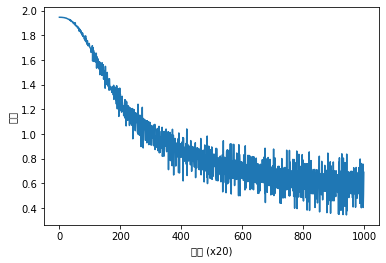

In [63]:
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [64]:
word_vecs = model.word_vecs#분산표현(각 행에는 대응하는 단어ID의 분산표현이 저장)

In [65]:
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])#분산표현은 '단어의 의미'를 잘 파악한 벡터 표현으로 됨

you [-1.1679507 -1.0968632 -1.2468287  1.1851399  1.0914993]
say [ 1.1523733   1.1545821   0.16450512 -1.1587288  -1.148271  ]
goodbye [-0.7321581  -0.7841063  -0.7544177   0.68122596  0.8082298 ]
and [ 0.8838082   0.93815774 -2.1286018  -0.9225632  -0.95059866]
i [-0.72541004 -0.7805191  -0.75435317  0.6696604   0.80504644]
hello [-1.1657225 -1.087954  -1.2484682  1.193337   1.1115   ]
. [ 1.1085235  1.118763   1.7275089 -1.1137029 -1.0881041]


$$P(w_t|w_{t-1},w_{t+1})$$
<br><br>
<b>음의 로그 가능도 negative log likelihood</b>
$$L = \frac{1}{T}\sum_{t=1}^T log P(w_t|w_{t-1},w_{t+1})$$